# Model Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import tifffile as tiff

## Load training and label

In [2]:
# DATOS_train
datos_train = pd.read_csv("data/DATOS_train.csv")

In [3]:
path_feats = "data/train_features/content/train_features/"
path_labels = "data/train_labels/content/train_labels/"

In [4]:
feats = []
labels = []
for n in range(len(datos_train)):
    path_feat = datos_train.iloc[n].feature_image
    path_label = datos_train.iloc[n].label_image
    feat = tiff.imread(path_feats + path_feat)
    label = tiff.imread(path_labels + path_label)
    
    feats.append(feat)
    labels.append(label)
    
feats = np.array(feats)
labels = np.array(labels)

In [5]:
feats.shape, labels.shape

((5317, 128, 128, 10), (5317, 128, 128))

In [6]:
feats.min(), feats.max()

(-3.4028235e+38, 1.0)

In [7]:
labels.min(), labels.max()

(0, 15)

In [8]:
from collections import Counter
Counter(labels.flatten())

Counter({4: 32841983,
         2: 26621292,
         0: 6274714,
         6: 290550,
         1: 4317735,
         5: 6097122,
         7: 10616479,
         15: 53853})

## Prepocess Features
Scale

In [9]:
np.min(feats[1][:, :, 1])

0.0785724

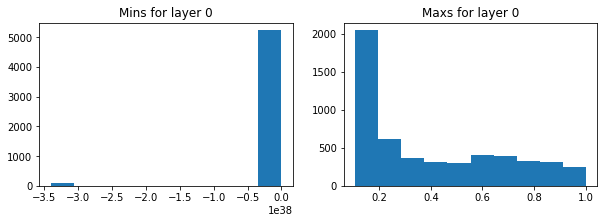

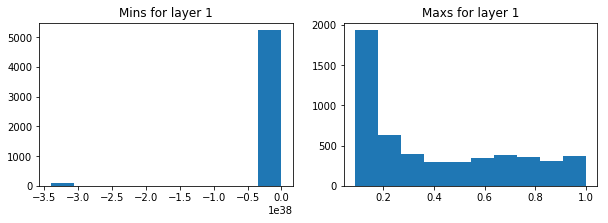

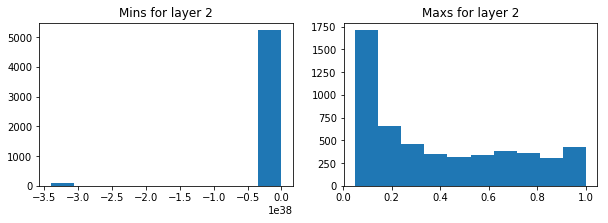

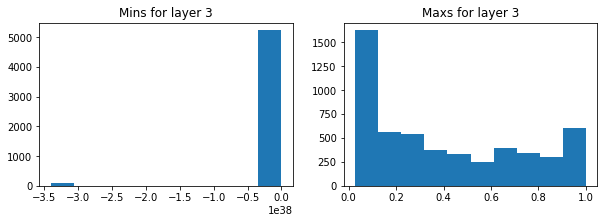

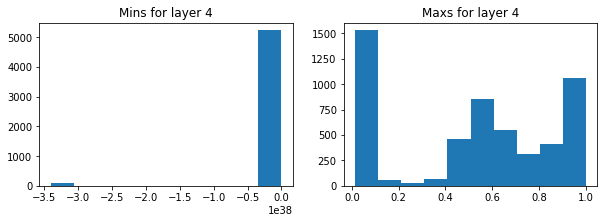

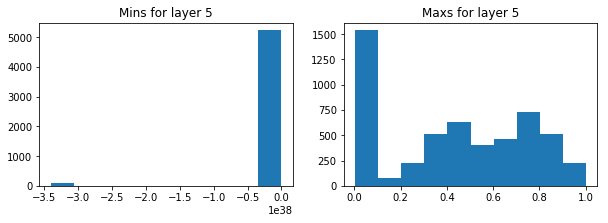

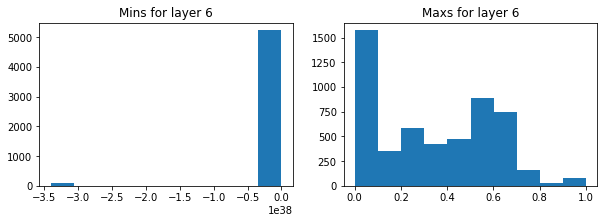

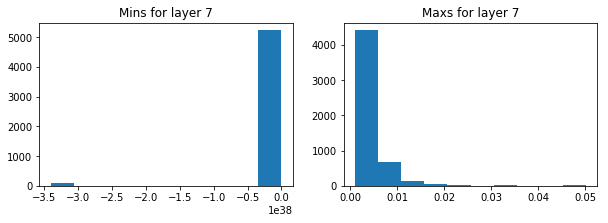

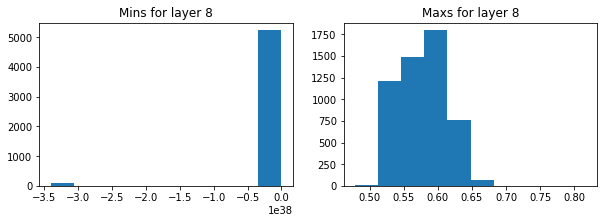

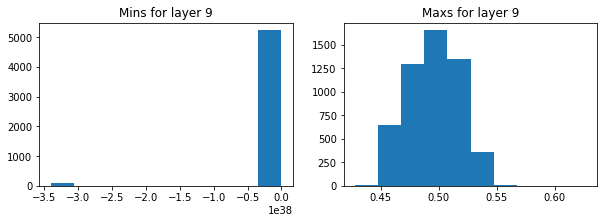

In [10]:
# distribution per layer

for i in range(10):
    mins = []
    maxs = []
    for j in range(feats.shape[0]):
        vals = feats[j][:, :, i].flatten()
        min_ = vals.min()
        max_ = vals.max()
    
        mins.append(min_)
        maxs.append(max_)

    f, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].hist(mins)
    ax[0].set_title(f'Mins for layer {i}')
    ax[1].hist(maxs)
    ax[1].set_title(f'Maxs for layer {i}')
    plt.show()
    
    

In [11]:
# which have minimum values < - 1?
outliers = []
for i in feats:
    if np.min(i) < -1:
        outliers.append(i)

In [12]:
len(outliers)

96

In [13]:
# we remove outliers
feats_final = []
labels_final0 = []

for n in range(len(datos_train)):
    path_feat = datos_train.iloc[n].feature_image
    path_label = datos_train.iloc[n].label_image
    
    feat = tiff.imread(path_feats + path_feat)
    label = tiff.imread(path_labels + path_label)
    
    if feat.min() >= -1:
        feats_final.append(feat)
        labels_final0.append(label)
    
feats_final = np.array(feats_final)
labels_final0 = np.array(labels_final0)

In [14]:
feats_final.shape, labels_final0.shape

((5221, 128, 128, 10), (5221, 128, 128))

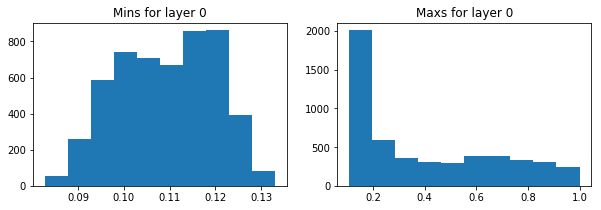

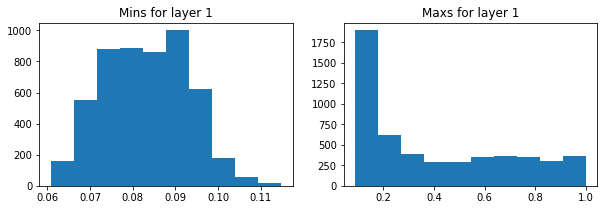

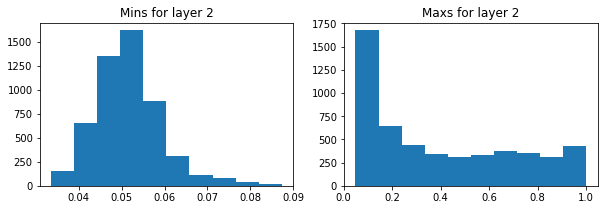

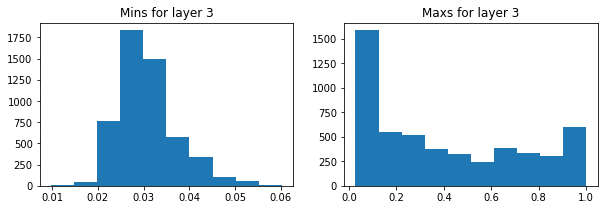

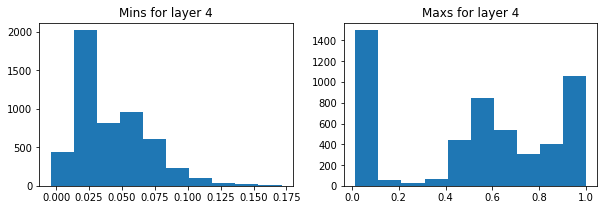

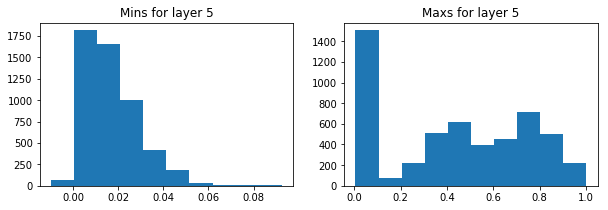

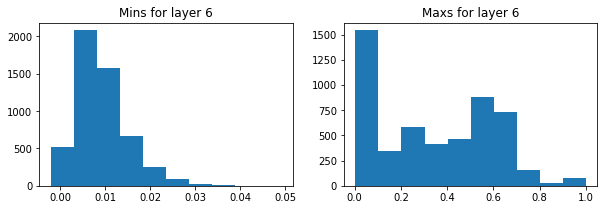

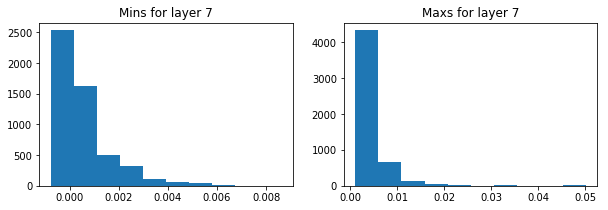

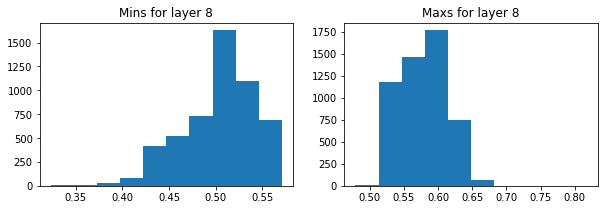

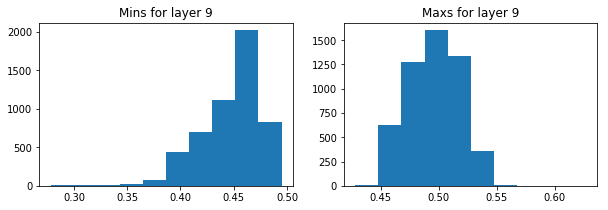

In [15]:
# distribution per layer

for i in range(10):
    mins = []
    maxs = []
    for j in range(feats_final.shape[0]):
        vals = feats_final[j][:, :, i].flatten()
        min_ = vals.min()
        max_ = vals.max()
    
        mins.append(min_)
        maxs.append(max_)

    f, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].hist(mins)
    ax[0].set_title(f'Mins for layer {i}')
    ax[1].hist(maxs)
    ax[1].set_title(f'Maxs for layer {i}')
    plt.show()
    
    

## Preprocess label (separate per class)
Optional. We split each prediction into a 128 X 128 X 8 tensor. Each of the 8 layers correspond to classes 0, 1, 2, 4, 5, 6, 7, 15.

In [16]:
sample_label = labels_final0[3]
sample_label.shape

(128, 128)

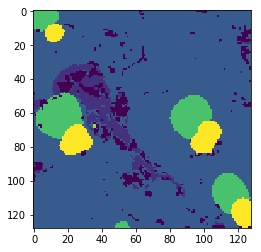

In [17]:
plt.imshow(sample_label)

In [18]:
def split_array(sample_label):
    new_array = []

    for i in [0, 1, 2, 4, 5, 6, 7, 15]:
        layer = sample_label==i
        layer = layer.astype(int)
        new_array.append(layer)
    new_array = np.array(new_array)
    new_array = np.swapaxes(new_array, 0, 2)
    
    return new_array

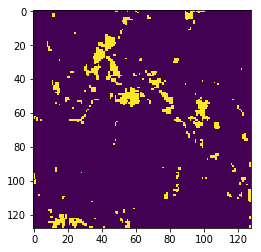

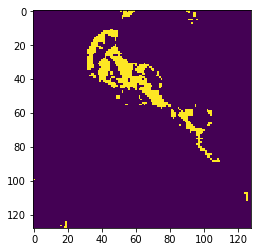

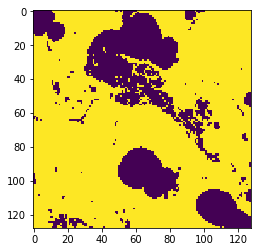

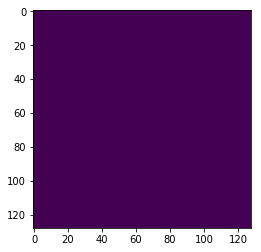

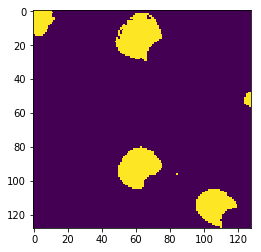

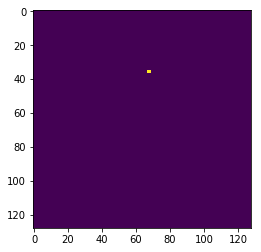

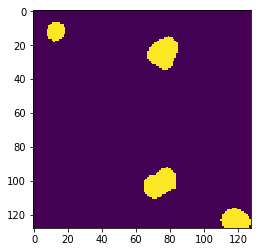

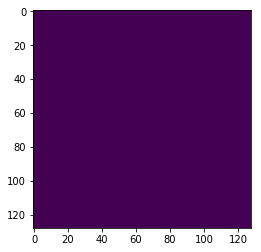

In [19]:
sample_split = split_array(sample_label)
for i in range(8):
    plt.imshow(sample_split[:, :, i])
    plt.show()

In [20]:
labels_final = np.array([split_array(i) for i in labels_final0])

In [21]:
labels_final.shape

(5221, 128, 128, 8)

In [22]:
feats_final.shape, labels_final.shape

((5221, 128, 128, 10), (5221, 128, 128, 8))

In [23]:
## Compress labels

def compress_label(matrix):
    classes = [0, 1, 2, 4, 5, 6, 7, 15]

    new_array = []
    for i in range(8):
        layer = matrix[:, :, i]
        layer = layer * classes[i]
        new_array.append(layer)
    new_array = np.array(new_array)
    new_array = np.swapaxes(new_array, 0, 2)
    new_array = np.sum(new_array, axis=2)
    
    return new_array

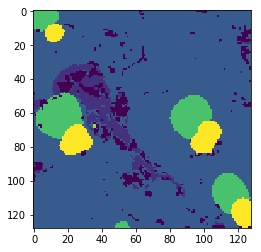

In [24]:
plt.imshow(labels_final0[3])

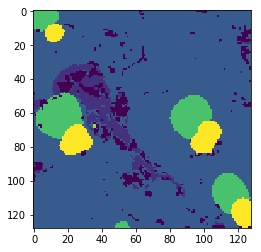

In [25]:
plt.imshow(compress_label(labels_final[3]))

# Model Definitions

In [26]:
# example of defining a 70x70 patchgan discriminator model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Dropout

from PIL import Image

### Encoder and Decoder Definition

In [27]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

In [28]:
# define the standalone generator model
def define_generator(image_shape=(128,128,10)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model: C64-C128-C256
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e3)
    b = Activation('relu')(b)
    # decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    d1 = decoder_block(b, e3, 256, dropout=False)
    d2 = decoder_block(d1, e2, 128, dropout=False)
    d3 = decoder_block(d2, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(8, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d3)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

### Define Sample Generation

In [36]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    
    return [X1, X2]

### Date for Naming

In [30]:
from datetime import date
today = str(date.today().year)+'_'+str(date.today().month)+'_'+str(date.today().day)

### Standard U-Net

In [31]:
# define image shape
image_shape = (128,128,10)
# create the model
unet_model = define_generator(image_shape)

opt = Adam(lr=0.0002, beta_1=0.5)
unet_model.compile(loss='binary_crossentropy', optimizer=opt)

# summarize the model
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 10 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   10304       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  131200      leaky_re_lu[0][0]                
______________________________________________________________________________________________

### U-Net with Adversarial Loss on Prediction Network

### WGANs

## Training and Cross Validation
We measure:
<br>1) Average of intersection over Union for each of the classes
<br>2) Pixel-by-pixel accuracy

We use k-fold cross-validation on the training set

In [32]:
# k-fold cross validation function

def get_train_valid(num_samples, k):
    valid_inds = []
    train_inds = []
    
    num_valid = num_samples // k
    num_train = num_samples - num_valid
    
    for i in range(k):
        valid_ind = np.arange(num_valid * i, num_valid * i + num_valid)
        train_ind = np.array([i for i in np.arange(num_samples) if i not in valid_ind])
        
        valid_inds.append(valid_ind)
        train_inds.append(train_ind)
        
    return valid_inds, train_inds
#         print(valid_inds[0], valid_inds[-1])
#         print(len(valid_inds))
#         print(len(train_inds))

### Standard U-net

In [33]:
# train pix2pix models
def train(g_model, dataset, n_epochs=1, n_batch=1):
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    print(n_steps)
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB] = generate_real_samples(dataset, n_batch)
        # update the generator
        g_loss = g_model.train_on_batch(X_realA, X_realB)
        # summarize performance
        if i % 100 == 0:
            print('>%d, g[%.3f]' % (i+1, g_loss))

In [34]:
num_samples = feats_final.shape[0]
k = 3
valid_inds, train_inds = get_train_valid(num_samples, k)

i = 0
train_feats = feats_final[train_inds[i]]
valid_feats = feats_final[valid_inds[i]]

train_labels = labels_final[train_inds[i]]
valid_labels = labels_final[valid_inds[i]]

# train_feats.shape, valid_feats.shape, train_labels.shape, valid_labels.shape

In [37]:
# get n random images from all images in the dataset
    
filename_g = f'models/datos_unet_gen_{today}'

# concatentate dataset
dataset = [train_feats, train_labels]

# train model
train(unet_model, dataset, n_epochs=10, n_batch=500)

# save the generator model
unet_model.save(f"{filename_g}.h5")
print(f'saved generator model in {filename_g}.h5')


# check on validation
for i in range(5):

    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    valid_feat = valid_feats[i]
    valid_true = valid_labels[i]
    valid_true = compress_label(valid_true)
    
    # show true
    axs[0].imshow(valid_labels)

    # predict sample with values from 0 to 1
    valid_pred = unet_model.predict(valid_feat)
    valid_pred = compress_label(valid_pred)

    axs[1].imshow(valid_pred)

    plt.show()

3480
>1, g[1.293]


KeyboardInterrupt: 

(128, 128, 10)


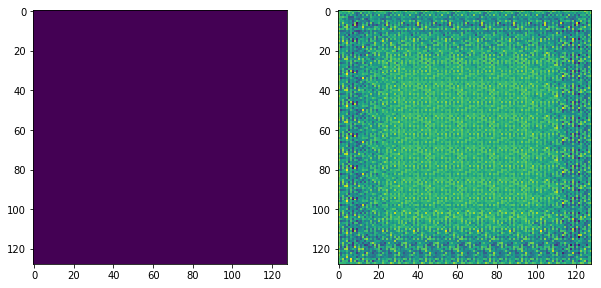

(128, 128, 10)


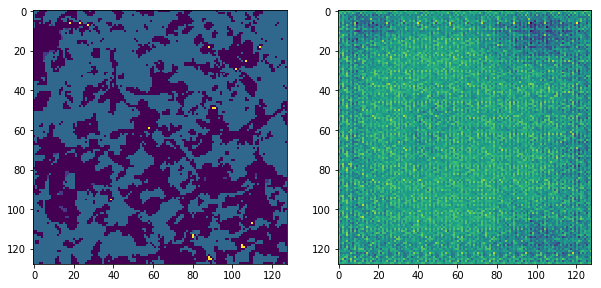

(128, 128, 10)


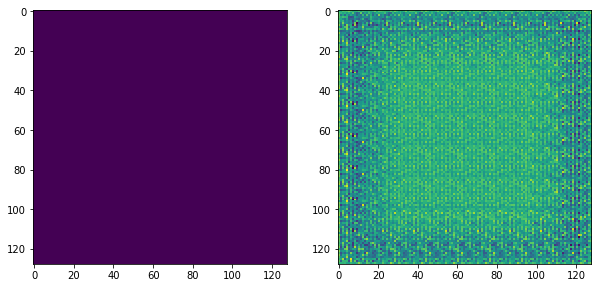

(128, 128, 10)


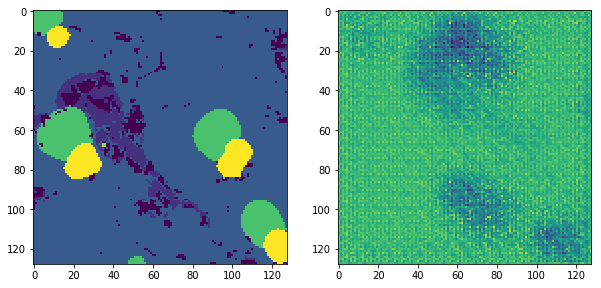

(128, 128, 10)


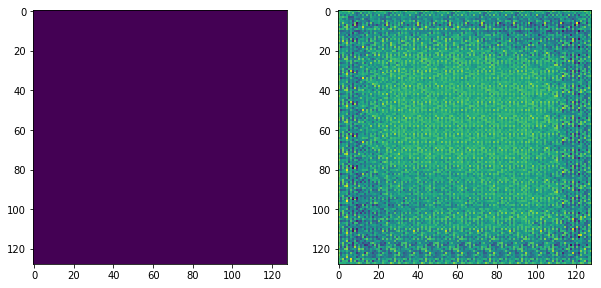

In [47]:
for i in range(5):

    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    valid_feat = valid_feats[i]
    valid_true = valid_labels[i]
    valid_true = compress_label(valid_true)
    
    print(valid_feat.shape)
    
    # show true
    axs[0].imshow(valid_true)

    # predict sample with values from 0 to 1
    valid_pred = unet_model.predict(np.reshape(valid_feat, (1, 128, 128, 10)))
    valid_pred = compress_label(valid_pred[0])

    axs[1].imshow(valid_pred)

    plt.show()

## Test Prediction

## Submission File